# Visualiser for dummy area28 metric data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [154]:
# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1,CORE_SCENE_JOIN,3,0,14,2024-03-11 23:07:56,{'rating': None}
2,CORE_SCENE_LEAVE,3,0,14,2024-03-12 02:48:40,{'rating': None}
3,CORE_SCENE_RATE,3,0,14,2024-03-12 02:50:03,{'rating': 0}
4,CORE_SCENE_JOIN,5,1,1,2020-05-18 16:54:37,{'rating': None}
5,CORE_SCENE_LEAVE,5,1,1,2020-05-18 19:40:09,{'rating': None}
...,...,...,...,...,...,...
241,CORE_SCENE_RATE,1,97,10,2021-11-04 11:15:29,{'rating': 4}
242,CORE_SCENE_JOIN,4,98,6,2021-10-20 00:25:47,{'rating': None}
243,CORE_SCENE_LEAVE,4,98,6,2021-10-20 05:43:01,{'rating': None}


In [155]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId', 'sessionId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'sessionId', 'date', 'duration', 'time', 'weekday', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed

,userId,sessionId,date,duration,time,weekday,sceneId
id,,,,,,,
2,3,0,2024-03-12,0 days 03:40:44,02:48:40,Tuesday,14
5,5,1,2020-05-18,0 days 02:45:32,19:40:09,Monday,1
8,2,2,2022-05-22,0 days 04:00:18,19:31:47,Sunday,19
10,4,3,2023-05-31,0 days 03:40:48,04:19:05,Wednesday,13
13,3,4,2021-05-14,0 days 04:03:44,15:16:59,Friday,19
...,...,...,...,...,...,...,...
235,8,95,2023-08-28,0 days 05:43:09,14:22:36,Monday,3
238,5,96,2023-04-12,0 days 03:05:35,11:43:02,Wednesday,2
240,1,97,2021-11-04,0 days 01:15:17,11:15:09,Thursday,10


In [173]:
df_no_rating.head()

,type,userId,sessionId,sceneId,timestamp,data,datetime,date,time,weekday,duration
id,,,,,,,,,,,
1,CORE_SCENE_JOIN,3,0,14,2024-03-11 23:07:56,{'rating': None},2024-03-11 23:07:56,2024-03-11,23:07:56,Monday,NaT
2,CORE_SCENE_LEAVE,3,0,14,2024-03-12 02:48:40,{'rating': None},2024-03-12 02:48:40,2024-03-12,02:48:40,Tuesday,0 days 03:40:44
4,CORE_SCENE_JOIN,5,1,1,2020-05-18 16:54:37,{'rating': None},2020-05-18 16:54:37,2020-05-18,16:54:37,Monday,NaT
5,CORE_SCENE_LEAVE,5,1,1,2020-05-18 19:40:09,{'rating': None},2020-05-18 19:40:09,2020-05-18,19:40:09,Monday,0 days 02:45:32
7,CORE_SCENE_JOIN,2,2,19,2022-05-22 15:31:29,{'rating': None},2022-05-22 15:31:29,2022-05-22,15:31:29,Sunday,NaT


In [121]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

In [122]:
import ipywidgets as widgets
menu = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       value='Week',
       description='Timeframe:')
menu

Dropdown(description='Timeframe:', index=1, options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Week'…

In [123]:
menu.value

'Week'

# Pie chart of time spent in different scenes

In [175]:
df_sessions = ['1', '2', '3']
# df_sessions = df_processed.groupby(['sceneId'])['duration'].sum()
df_sessions = pd.DataFrame({'duration' : df_processed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
df_sessions.head()

,sceneId,duration
0,0,0 days 02:49:02
1,1,1 days 03:40:40
2,2,0 days 20:38:33
3,3,0 days 20:19:34
4,4,0 days 10:20:12


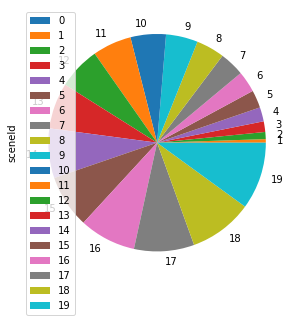

In [126]:
plot = df_sessions.plot.pie(y='sceneId', figsize=(5, 5))

### Bar Chart showing how long users spent in sessions

<BarContainer object of 100 artists>

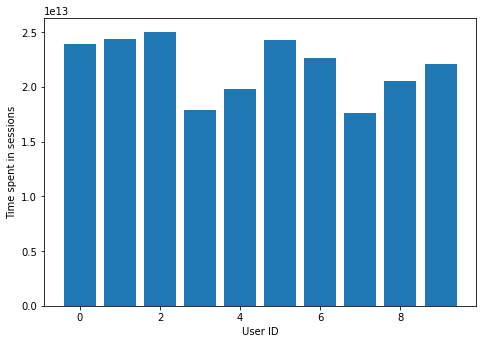

In [127]:
# df_processed.plot(x="userId", y=["times"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Time spent in sessions')
ax.set_xlabel('User ID')
ax.bar(df_processed['userId'], df_processed['duration'])

# Heatmap showing time spent in session for each user during a week

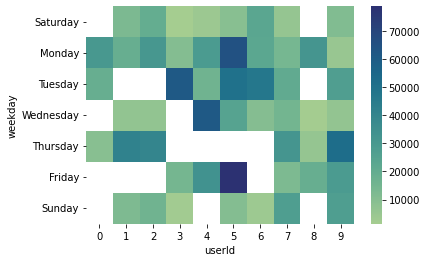

In [128]:
from pandas import DataFrame
import seaborn as sns
import time
%matplotlib inline

df_processed['seconds'] = [d.total_seconds() for d in df_processed['duration']]

df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed.groupby(['userId', 'weekday'])['seconds'].sum()}).reset_index()

df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='userId', values='seconds')
df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
df_heatmap.sort_index(level=0, inplace=True)

sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest')
plt.show()

In [129]:
df_processed_groupedbyID.head()


,userId,weekday,seconds
0,0,Monday,30384.0
1,0,Thursday,9344.0
2,0,Tuesday,18756.0
3,1,Monday,18713.0
4,1,Saturday,12619.0


In [130]:
# histogram showing concurrent users in a scene (throughout day)
# smiley face rating for users to rate the session (store in data)
# histogram showing length of session for users in a week (timeframe)

## Show ratings of users


In [162]:
df_rating = df.drop(df[df['type'] != "CORE_SCENE_RATE"].index)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
3,CORE_SCENE_RATE,3,0,14,2024-03-12 02:50:03,{'rating': 0}
6,CORE_SCENE_RATE,5,1,1,2020-05-18 19:41:21,{'rating': 3}
11,CORE_SCENE_RATE,4,3,13,2023-05-31 04:20:21,{'rating': 4}
14,CORE_SCENE_RATE,3,4,19,2021-05-14 15:17:52,{'rating': 0}
17,CORE_SCENE_RATE,9,5,16,2024-09-19 04:48:00,{'rating': 0}


In [163]:
import ast
df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
df_rating = df_rating.drop('data', axis=1)
df_rating = df_rating.drop('data_str', axis=1)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,rating
id,,,,,,
3,CORE_SCENE_RATE,3,0,14,2024-03-12 02:50:03,0
6,CORE_SCENE_RATE,5,1,1,2020-05-18 19:41:21,3
11,CORE_SCENE_RATE,4,3,13,2023-05-31 04:20:21,4
14,CORE_SCENE_RATE,3,4,19,2021-05-14 15:17:52,0
17,CORE_SCENE_RATE,9,5,16,2024-09-19 04:48:00,0


In [182]:
df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["rating"])['type']}).reset_index()
df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
df_rating_grouped.columns = ['rating', 'count']
df_rating_grouped


,rating,count
0,0,12
1,1,5
2,2,10
3,3,10
4,4,8


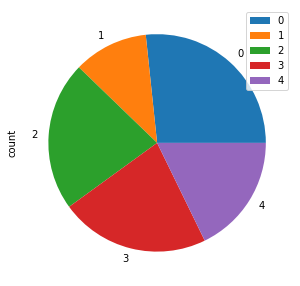

In [188]:
plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))

In [225]:
dt.datetime.now().timestamp()

1635923956.821516